In [1]:
%run -i 'cosim_import.py'

1.7.2.post298.dev0+ge5e45819
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18

# --- ANDES case ---
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_eva.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=False,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ssa.TDS.config.save_mode = 'manual'
ssa.TDS.config.no_tqdm = 1

# Set load as constant load.
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ssa.config.numba = 1

ss2 = andes.load(case,
                 setup=False,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ss2.TDS.config.save_mode = 'manual'
ss2.TDS.config.no_tqdm = 1

# Set load as constant load.
ss2.PQ.config.p2p = 1
ss2.PQ.config.q2q = 1
ss2.PQ.config.p2z = 0
ss2.PQ.config.q2z = 0
ss2.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ss2.config.numba = 1

Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3055 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_eva.xlsx"...
Input file parsed in 0.1451 seconds.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.4190 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_eva.xlsx"...
Input file parsed in 0.1474 seconds.


In [3]:
# --- EV Aggregator ---
sse = ev_ssm(ts=caseH, N=1000, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=18[H], 1000 EVs, Total Q=8.38 MWh
Online 290, Q=7.31 MWh, SoC=0.7749
Power(MW): Pt=-0.7659, Pc=-0.7659, Pd=-0.0
Ctrl: 0=161; 1=129; 
EVA: Load A from Aest.csv.


In [4]:
for i in range(sse.ev.shape[0]):
    ev_dict = {'bus':38, 'gen':'PV_10',
            'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
            'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': 10, 'EtaD': 10, 
            'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
            'pqflag':1, 'vrflag':0}
    ssa.add("EV2", ev_dict)
# TODO: alter gammap, gammpaq, pmx, pmn, EtaC, EtaD, En later on
ev_df = sse.ev.copy()
ev_df['p'] = -1 * ev_df['c'] * ev_df['Pc']
ev_df['gammap'] = ev_df['p'] / ev_df['p'].sum()
ev_df['gammaq'] = 1 / ev_df.u.sum()
ev_df['EtaC'] = ev_df['nc']
ev_df['EtaD'] = ev_df['nd']
ev_df['En'] = ev_df['Q'] / 1e3
ev_df['SOCinit'] = ev_df['soc'].replace(1, 0.999)
# ev_df['pmx'] = ev_df['Pc'] / 1e3 / ssa.config.mva
# ev_df['pmn'] = -1 * ev_df['Pc'] / 1e3 / ssa.config.mva
ev_df['u'] = ev_df['u']

ev_idx = ssa.EV2.idx.v
ssa.DG.set(attr='v', idx=ev_idx, src='gammap', value=ev_df['gammap'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='gammaq', value=ev_df['gammaq'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='EtaC', value=ev_df['EtaC'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='EtaD', value=ev_df['EtaD'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='En', value=ev_df['En'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='SOCinit', value=ev_df['SOCinit'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='u', value=ev_df['u'].values)

# TODO: alter PV_10.p0
p0 = ev_df['p'].sum() / 1e3 / ssa.config.mva
ssa.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
ssa.setup()
ssa.PFlow.run()
ssa.TDS.init()

ev0_dict = {'bus':38, 'gen':'PV_10',
        'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
        'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': ev_df['EtaC'].mean(), 'EtaD': ev_df['EtaD'].mean(), 
        'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
        'pqflag':1, 'vrflag':0}

ss2.add("EV2", ev0_dict)
ss2.setup()
ss2.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
ss2.PFlow.run()
xx = ss2.TDS.init()

ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0586 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1703 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916465285
2: |F(x)| = 0.1312863918
3: |F(x)| = 0.000348892072
4: |F(x)| = 4.216807348e-09
Converged in 5 iterations in 0.0178 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initializati

In [5]:
for end_time in range(1, 600):
    sse.run(tf=caseH+end_time/3600, Pi=0,
            is_updateA=False, is_rstate=True,
            is_test=False, disable=True)
    ssa.DG.set(attr='v', idx=ev_idx, src='u', value=sse.ev['u'].values)
    ssa.DG.set(attr='v', idx=ev_idx, src='pref0',
               value=list(-1 * sse.ev['c'] * sse.ev['Pc'] / ssa.config.mva / 1e3))
    ss2.DG.set(attr='v', idx='EV2_1', src='pref0',
               value=np.sum(-1 * sse.ev['c'] * sse.ev['Pc'] / ssa.config.mva / 1e3))
    
    ssa.TDS.config.tf = end_time
    ss2.TDS.config.tf = end_time
    ssa.TDS.run()
    ss2.TDS.run()
    
    if ssa.exit_code != 0 | ss2.exit_code != 0:
        break


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=1.00 sec completed in 0.1049 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=1.00 sec completed in 0.0596 seconds.
Simulation to t=2.00 sec completed in 0.3392 seconds.
Simulation to t=2.00 sec completed in 0.1314 seconds.
Simulation to t=3.00 sec completed in 0.2586 seconds.
Simulation to t=3.00 sec completed in 0.1092 seconds.
Simulation to t=4.00 sec completed in 0.1994 seconds.
Simulation to t=4.00 sec completed in 0.0791 seconds.
Simulation to t=5.00 sec completed in 0.1994 seconds.
Simulation to t=5.00 sec completed in 0.1003 seconds.
Simulation to t=6.00 sec completed in 0.1940 seconds.
Simulation to t=6.00 sec completed in 0.0793 seconds.
Simulation to t=7.00 sec completed in 0.1739 seconds.
Simulation to t=7.00 sec com

Simulation to t=73.00 sec completed in 0.0799 seconds.
Simulation to t=74.00 sec completed in 0.2181 seconds.
Simulation to t=74.00 sec completed in 0.1797 seconds.
Simulation to t=75.00 sec completed in 0.1839 seconds.
Simulation to t=75.00 sec completed in 0.0829 seconds.
Simulation to t=76.00 sec completed in 0.1767 seconds.
Simulation to t=76.00 sec completed in 0.1022 seconds.
Simulation to t=77.00 sec completed in 0.2081 seconds.
Simulation to t=77.00 sec completed in 0.0887 seconds.
Simulation to t=78.00 sec completed in 0.1835 seconds.
Simulation to t=78.00 sec completed in 0.0799 seconds.
Simulation to t=79.00 sec completed in 0.1990 seconds.
Simulation to t=79.00 sec completed in 0.1039 seconds.
Simulation to t=80.00 sec completed in 0.1816 seconds.
Simulation to t=80.00 sec completed in 0.0787 seconds.
Simulation to t=81.00 sec completed in 0.1751 seconds.
Simulation to t=81.00 sec completed in 0.1006 seconds.
Simulation to t=82.00 sec completed in 0.2222 seconds.
Simulation

Simulation to t=147.00 sec completed in 0.0879 seconds.
Simulation to t=148.00 sec completed in 0.1783 seconds.
Simulation to t=148.00 sec completed in 0.1195 seconds.
Simulation to t=149.00 sec completed in 0.1992 seconds.
Simulation to t=149.00 sec completed in 0.0827 seconds.
Simulation to t=150.00 sec completed in 0.1693 seconds.
Simulation to t=150.00 sec completed in 0.0998 seconds.
Simulation to t=151.00 sec completed in 0.1984 seconds.
Simulation to t=151.00 sec completed in 0.0818 seconds.
Simulation to t=152.00 sec completed in 0.1804 seconds.
Simulation to t=152.00 sec completed in 0.1012 seconds.
Simulation to t=153.00 sec completed in 0.2815 seconds.
Simulation to t=153.00 sec completed in 0.0800 seconds.
Simulation to t=154.00 sec completed in 0.1780 seconds.
Simulation to t=154.00 sec completed in 0.1045 seconds.
Simulation to t=155.00 sec completed in 0.1824 seconds.
Simulation to t=155.00 sec completed in 0.0801 seconds.
Simulation to t=156.00 sec completed in 0.1777 s

Simulation to t=221.00 sec completed in 0.2560 seconds.
Simulation to t=221.00 sec completed in 0.0775 seconds.
Simulation to t=222.00 sec completed in 0.2228 seconds.
Simulation to t=222.00 sec completed in 0.1022 seconds.
Simulation to t=223.00 sec completed in 0.1991 seconds.
Simulation to t=223.00 sec completed in 0.0790 seconds.
Simulation to t=224.00 sec completed in 0.1901 seconds.
Simulation to t=224.00 sec completed in 0.0837 seconds.
Simulation to t=225.00 sec completed in 0.2381 seconds.
Simulation to t=225.00 sec completed in 0.0851 seconds.
Simulation to t=226.00 sec completed in 0.1879 seconds.
Simulation to t=226.00 sec completed in 0.0887 seconds.
Simulation to t=227.00 sec completed in 0.1792 seconds.
Simulation to t=227.00 sec completed in 0.0962 seconds.
Simulation to t=228.00 sec completed in 0.2061 seconds.
Simulation to t=228.00 sec completed in 0.0803 seconds.
Simulation to t=229.00 sec completed in 0.1689 seconds.
Simulation to t=229.00 sec completed in 0.0803 s

Simulation to t=294.00 sec completed in 0.0716 seconds.
Simulation to t=295.00 sec completed in 0.1802 seconds.
Simulation to t=295.00 sec completed in 0.0708 seconds.
Simulation to t=296.00 sec completed in 0.1505 seconds.
Simulation to t=296.00 sec completed in 0.0711 seconds.
Simulation to t=297.00 sec completed in 0.1625 seconds.
Simulation to t=297.00 sec completed in 0.0715 seconds.
Simulation to t=298.00 sec completed in 0.1568 seconds.
Simulation to t=298.00 sec completed in 0.0686 seconds.
Simulation to t=299.00 sec completed in 0.1520 seconds.
Simulation to t=299.00 sec completed in 0.0765 seconds.
Simulation to t=300.00 sec completed in 0.1540 seconds.
Simulation to t=300.00 sec completed in 0.0720 seconds.
Simulation to t=301.00 sec completed in 0.1504 seconds.
Simulation to t=301.00 sec completed in 0.0714 seconds.
Simulation to t=302.00 sec completed in 0.1578 seconds.
Simulation to t=302.00 sec completed in 0.0704 seconds.
Simulation to t=303.00 sec completed in 0.1492 s

Simulation to t=368.00 sec completed in 0.1592 seconds.
Simulation to t=368.00 sec completed in 0.0707 seconds.
Simulation to t=369.00 sec completed in 0.1651 seconds.
Simulation to t=369.00 sec completed in 0.0730 seconds.
Simulation to t=370.00 sec completed in 0.1500 seconds.
Simulation to t=370.00 sec completed in 0.0708 seconds.
Simulation to t=371.00 sec completed in 0.1521 seconds.
Simulation to t=371.00 sec completed in 0.0709 seconds.
Simulation to t=372.00 sec completed in 0.1479 seconds.
Simulation to t=372.00 sec completed in 0.0730 seconds.
Simulation to t=373.00 sec completed in 0.1592 seconds.
Simulation to t=373.00 sec completed in 0.0683 seconds.
Simulation to t=374.00 sec completed in 0.1495 seconds.
Simulation to t=374.00 sec completed in 0.0736 seconds.
Simulation to t=375.00 sec completed in 0.1521 seconds.
Simulation to t=375.00 sec completed in 0.0704 seconds.
Simulation to t=376.00 sec completed in 0.1490 seconds.
Simulation to t=376.00 sec completed in 0.0698 s

Simulation to t=441.00 sec completed in 0.0692 seconds.
Simulation to t=442.00 sec completed in 0.1450 seconds.
Simulation to t=442.00 sec completed in 0.0727 seconds.
Simulation to t=443.00 sec completed in 0.1501 seconds.
Simulation to t=443.00 sec completed in 0.0723 seconds.
Simulation to t=444.00 sec completed in 0.1579 seconds.
Simulation to t=444.00 sec completed in 0.0733 seconds.
Simulation to t=445.00 sec completed in 0.1510 seconds.
Simulation to t=445.00 sec completed in 0.0720 seconds.
Simulation to t=446.00 sec completed in 0.1668 seconds.
Simulation to t=446.00 sec completed in 0.0697 seconds.
Simulation to t=447.00 sec completed in 0.1508 seconds.
Simulation to t=447.00 sec completed in 0.0723 seconds.
Simulation to t=448.00 sec completed in 0.1486 seconds.
Simulation to t=448.00 sec completed in 0.0725 seconds.
Simulation to t=449.00 sec completed in 0.1521 seconds.
Simulation to t=449.00 sec completed in 0.0702 seconds.
Simulation to t=450.00 sec completed in 0.1522 s

Simulation to t=515.00 sec completed in 0.1578 seconds.
Simulation to t=515.00 sec completed in 0.0844 seconds.
Simulation to t=516.00 sec completed in 0.1569 seconds.
Simulation to t=516.00 sec completed in 0.0722 seconds.
Simulation to t=517.00 sec completed in 0.1635 seconds.
Simulation to t=517.00 sec completed in 0.0775 seconds.
Simulation to t=518.00 sec completed in 0.1571 seconds.
Simulation to t=518.00 sec completed in 0.0733 seconds.
Simulation to t=519.00 sec completed in 0.1529 seconds.
Simulation to t=519.00 sec completed in 0.0770 seconds.
Simulation to t=520.00 sec completed in 0.1750 seconds.
Simulation to t=520.00 sec completed in 0.0742 seconds.
Simulation to t=521.00 sec completed in 0.1600 seconds.
Simulation to t=521.00 sec completed in 0.0919 seconds.
Simulation to t=522.00 sec completed in 0.1598 seconds.
Simulation to t=522.00 sec completed in 0.0716 seconds.
Simulation to t=523.00 sec completed in 0.1761 seconds.
Simulation to t=523.00 sec completed in 0.0727 s

Simulation to t=588.00 sec completed in 0.1128 seconds.
Simulation to t=589.00 sec completed in 0.1777 seconds.
Simulation to t=589.00 sec completed in 0.0731 seconds.
Simulation to t=590.00 sec completed in 0.1601 seconds.
Simulation to t=590.00 sec completed in 0.0755 seconds.
Simulation to t=591.00 sec completed in 0.1546 seconds.
Simulation to t=591.00 sec completed in 0.0737 seconds.
Simulation to t=592.00 sec completed in 0.1590 seconds.
Simulation to t=592.00 sec completed in 0.0790 seconds.
Simulation to t=593.00 sec completed in 0.1570 seconds.
Simulation to t=593.00 sec completed in 0.0748 seconds.
Simulation to t=594.00 sec completed in 0.1590 seconds.
Simulation to t=594.00 sec completed in 0.0722 seconds.
Simulation to t=595.00 sec completed in 0.1587 seconds.
Simulation to t=595.00 sec completed in 0.0795 seconds.
Simulation to t=596.00 sec completed in 0.1549 seconds.
Simulation to t=596.00 sec completed in 0.0757 seconds.
Simulation to t=597.00 sec completed in 0.1664 s

In [6]:
# calcualte output power
ia = ssa.dae.ts.x[:, ssa.EV2.Ipout_y.a]
va = ssa.dae.ts.y[:, ssa.EV2.v.a]
pa = np.sum(ia * va * ssa.config.mva, axis=1)

i2 = ss2.dae.ts.x[:, ss2.EV2.Ipout_y.a]
v2 = ss2.dae.ts.y[:, ss2.EV2.v.a]
p2 = np.sum(i2 * v2 * ssa.config.mva, axis=1)


Text(2879.179051052044, 0.5, 'Freq. [Hz]')

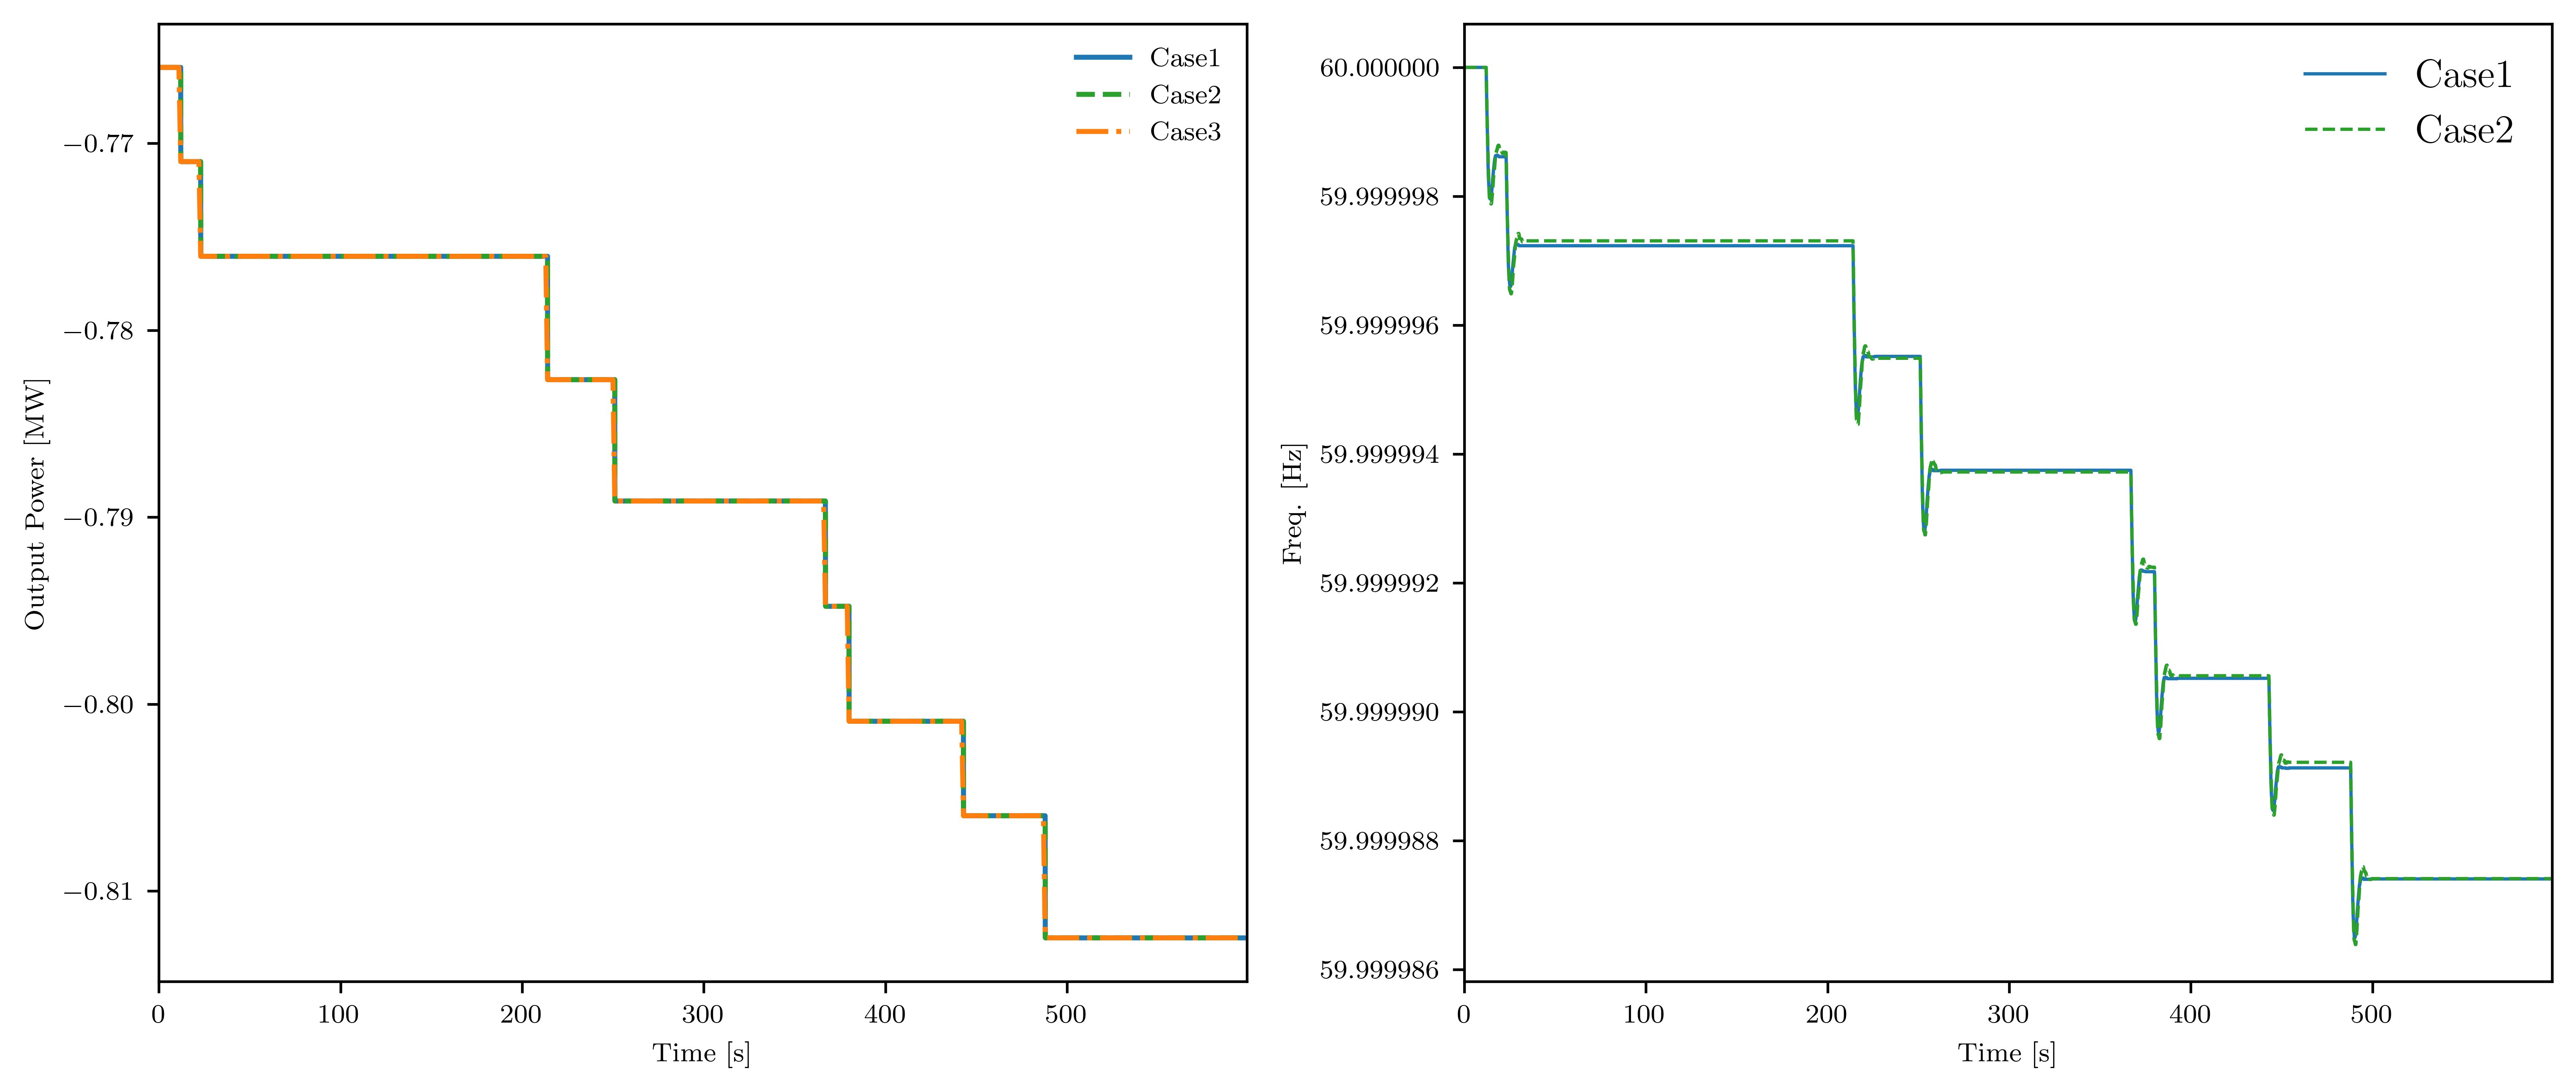

In [15]:
plt.style.use("ieee")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
ax[0].plot(ssa.dae.ts.t, pa, label="Case1", color="tab:blue")
ax[0].plot(ssa.dae.ts.t, p2, label="Case2", color="tab:green", linestyle="--")
ax[0].plot(3600*(np.array(sse.tss)-caseH), sse.Ptl, color="tab:orange", linestyle="-.", label="Case3")
ax[0].legend()
ax[0].set_xlim([0, end_time])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Output Power [MW]")
ax[0].legend(frameon=False)
ssa.TDS.plt.plot(ssa.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=['Case1'],
                 color="tab:blue", show=False)
ss2.TDS.plt.plot(ss2.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=["Case2"],
                 color="tab:green",  linestyles=['--'], show=False)
ax[1].set_ylabel('Freq. [Hz]')
# ax[1].plot(ssa.dae.ts.t, ssa.COI.omega, label="ANDES + Individual", color="tab:blue")
# ax[1].plot(ssa.dae.ts.t, p2, label="ANDES + Aggregated", color="tab:green", linestyle="--")
# ax[1].legend()

In [9]:
cosim_agg = pd.DataFrame()
cosim_agg['time'] = ssa.dae.ts.t
cosim_agg['pa'] = pa
cosim_agg['p2'] = p2
# cosim_agg['pev'] = sse.Ptl

In [ ]:
sse.plot()